# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [3]:
# TODO: Install any packages that you might need
!pip install tqdm
!pip install -U smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
# TODO: Import any packages that you might need
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import boto3
from sagemaker.pytorch import PyTorch
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import IPython
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import random
from math import floor
import shutil
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile, CollectionConfig
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts



role = sagemaker.get_execution_role()
bucket = 'inventory-monitoring-1'
s3_output_location = f"s3://{bucket}/models/image_model"
sagemaker_session = sagemaker.Session()
session = boto3.session.Session()
region = session.region_name

[2023-03-28 01:55:12.905 ip-172-16-90-228.ec2.internal:26047 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [5]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))


In [7]:
download_and_arrange_data()

100%|██████████| 1228/1228 [01:27<00:00, 13.98it/s]


100%|██████████| 2299/2299 [02:54<00:00, 13.19it/s]


100%|██████████| 2666/2666 [03:20<00:00, 13.31it/s]


 41%|████      | 973/2373 [01:17<01:52, 12.48it/s]


KeyboardInterrupt: 

## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

Total Images: 10441
Average expected quantity in a bin: 10441/5: 2088.2
Histogram of quantity distribution
total images with quantity 1 is 1228
total images with quantity 2 is 2299
total images with quantity 3 is 2666
total images with quantity 4 is 2373
total images with quantity 5 is 1875


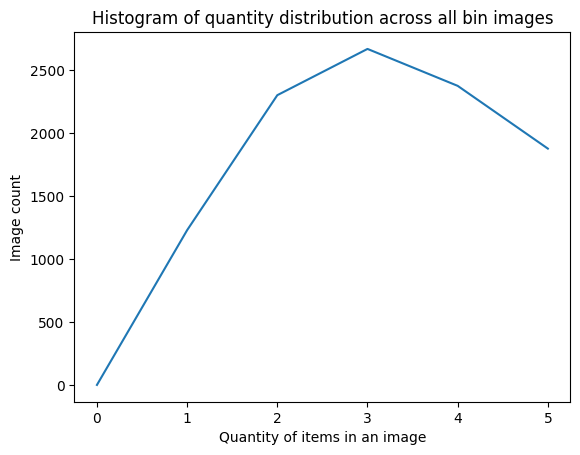

In [7]:
#TODO: Perform any data cleaning or data preprocessing

# getting total quantity across whole datasets
def get_total_quantity(dir_path):
    total_quantity = 0
     # = r'./train_data'
    for i in ['1', '2', '3', '4', '5']:
        for path in os.listdir(os.path.join(dir_path, i)):
            # print('path', path)
            # check if current path is a file
            if os.path.isfile(os.path.join(dir_path, i, path)):
                total_quantity += 1
    return total_quantity

def show_hist_quantity(dir_path):
    max_quantity = 5
    total_quantity = 0
    quantity_hist = np.zeros(max_quantity+1, dtype=int)
    for i in range(1, 6):
        total_quantity = 0
        for path in os.listdir(os.path.join(dir_path, str(i))):
            if os.path.isfile(os.path.join(dir_path, str(i), path)):
                total_quantity += 1
        quantity_hist[i] = quantity_hist[i] + total_quantity
        print(f"total images with quantity {str(i)} is {quantity_hist[i]}")
        
    np.savetxt("quantity_hist.csv",quantity_hist, fmt='%d')
    plt.plot(quantity_hist)
    # labels =  np.arange(1,6)
    # plt.bar(labels, quantity_hist, align='edge')
    plt.xlabel('Quantity of items in an image')
    plt.ylabel('Image count')
    plt.title('Histogram of quantity distribution across all bin images')
    plt.show()



def explore_data(dir_path):
    total_quantity = get_total_quantity(dir_path) 
    print("Total Images: " + str(total_quantity))
    print("Average expected quantity in a bin: " + str(total_quantity) + "/" 
          + str(5) + ": " + str(total_quantity/float(5)))

    print("Histogram of quantity distribution")
    show_hist_quantity(dir_path)

explore_data('./train_data')

### Resize Images

In [25]:
from PIL import Image
from os import listdir
import os.path


def resize_image():    
    dir_path = "./train_data"
    resized_img_dir = "./train_data_resize/"

    if not os.path.exists(resized_img_dir):
        os.makedirs(resized_img_dir)

    for i in ['1', '2', '3', '4', '5']:
        if not os.path.exists(os.path.join(resized_img_dir, i)):
            os.makedirs(os.path.join(resized_img_dir, i))
        for filename in os.listdir(os.path.join(dir_path, i)):
            if os.path.isfile(os.path.join(dir_path, i, filename)):
                image_path = os.path.join(dir_path, i, filename)
                resized_image_path = os.path.join(resized_img_dir,i,filename)
                img = Image.open(image_path).convert('RGB')
                resized_img = img.resize((224,224),Image.BILINEAR)
                resized_img.save(resized_image_path)
    

resize_image()

## Train Test dataset split

In [27]:
# Train, validation and Test data split


def test_train_split():
    dir_path = r'./train_data_resize'
    
    
    for i in ['1', '2', '3', '4', '5']:
        directory_train =os.path.join('train_data_split', 'train' , i)
        if not os.path.exists(directory_train):
            os.makedirs(directory_train)
        directory_valid=os.path.join('train_data_split', 'valid' , i)
        if not os.path.exists(directory_valid):
            os.makedirs(directory_valid)
        directory_test=os.path.join('train_data_split', 'test' , i)
        if not os.path.exists(directory_test):
            os.makedirs(directory_test)

        total_quantity = 0
        pname = os.path.join(dir_path, i)
        file_list = os.listdir(pname)
        if (file_list.count('.ipynb_checkpoints') > 0):
            file_list.remove('.ipynb_checkpoints')
        print(f"path {pname} has {len(file_list)} files")
        random.shuffle(file_list)
        
        train_size = floor(len(file_list) * .7)
        test_size = floor(len(file_list) * .15)
        
        # print(f"Expected train_size = {train_size} test_size = {test_size}")
        # print(f"train_idx_start = {0} train_idx_end = {train_size}")
        # print(f"valid_idx_start = {train_size+1} valid_idx_end = {train_size+test_size}")
        # print(f"test_idx_start = {train_size+test_size+1} test_idx_end = {len(file_list)}")
        train_list = file_list[:train_size+1]
        valid_list = file_list[train_size+1:train_size+test_size+1]
        test_list = file_list[train_size+test_size+1:]
        print(f"Actual train_size = {len(train_list)} valid_size = {len(valid_list)} test_size = {len(test_list)} total = {len(train_list) + len(valid_list) + len(test_list)}")

        for filename in train_list:
            # print(f"copying train file # {train_list.index(filename)} file {filename}")
            shutil.copyfile(os.path.join(pname, filename), os.path.join(directory_train, filename))

        for filename in valid_list:
            # print(f"copying valid_list file # {valid_list.index(filename)} file {filename}")
            shutil.copyfile(os.path.join(pname, filename), os.path.join(directory_valid, filename))
        
        for filename in test_list:
            # print(f"copying test_list file # {test_list.index(filename)} file {filename}")
            shutil.copyfile(os.path.join(pname, filename), os.path.join(directory_test, filename))


        

test_train_split()

path ./train_data_resize/1 has 1228 files
Actual train_size = 860 valid_size = 184 test_size = 184 total = 1228
path ./train_data_resize/2 has 2299 files
Actual train_size = 1610 valid_size = 344 test_size = 345 total = 2299
path ./train_data_resize/3 has 2666 files
Actual train_size = 1867 valid_size = 399 test_size = 400 total = 2666
path ./train_data_resize/4 has 2373 files
Actual train_size = 1662 valid_size = 355 test_size = 356 total = 2373
path ./train_data_resize/5 has 1875 files
Actual train_size = 1313 valid_size = 281 test_size = 281 total = 1875


Total Images: 7312
Average expected quantity in a bin: 7312/5: 1462.4
Histogram of quantity distribution
total images with quantity 1 is 860
total images with quantity 2 is 1610
total images with quantity 3 is 1867
total images with quantity 4 is 1662
total images with quantity 5 is 1313


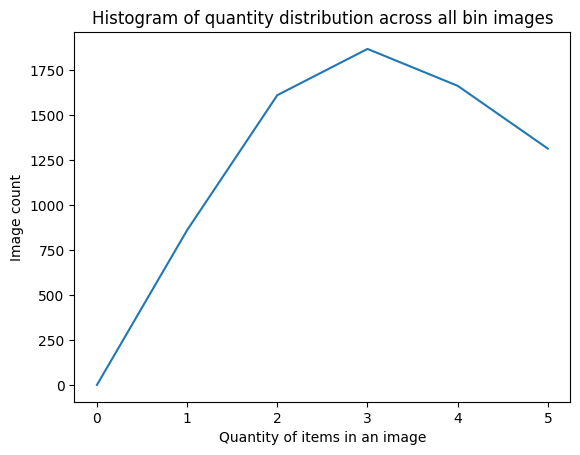

In [28]:
# Exploring Train dataset
explore_data('./train_data_split/train')

## Exploring Train, Validation and Tests datasets

Total Images: 1563
Average expected quantity in a bin: 1563/5: 312.6
Histogram of quantity distribution
total images with quantity 1 is 184
total images with quantity 2 is 344
total images with quantity 3 is 399
total images with quantity 4 is 355
total images with quantity 5 is 281


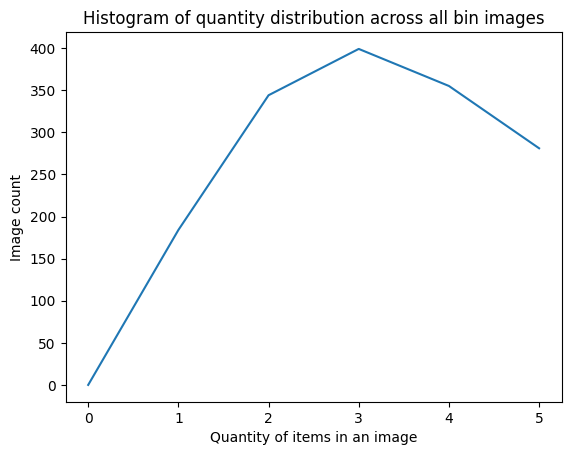

In [29]:
# Exploring Validation dataset
explore_data('./train_data_split/valid')

Total Images: 1566
Average expected quantity in a bin: 1566/5: 313.2
Histogram of quantity distribution
total images with quantity 1 is 184
total images with quantity 2 is 345
total images with quantity 3 is 400
total images with quantity 4 is 356
total images with quantity 5 is 281


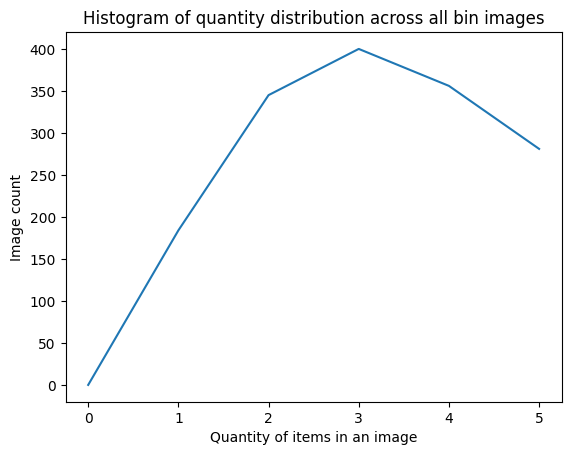

In [30]:
# Exploring Test dataset
explore_data('./train_data_split/test')

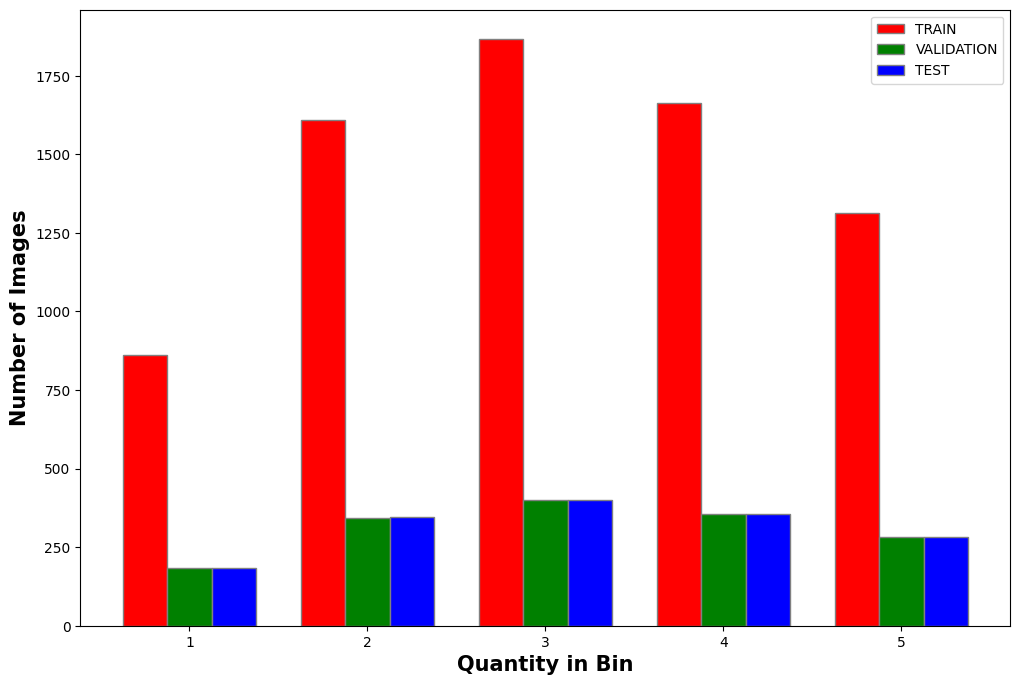

In [14]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
TRAIN = [860, 1610, 1867, 1662, 1313]
VALIDATION = [184, 344, 399, 355, 281]
TEST = [184, 345, 400, 356, 281]
 
# Set position of bar on X axis
br1 = np.arange(5)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, TRAIN, color ='r', width = barWidth,
        edgecolor ='grey', label ='TRAIN')
plt.bar(br2, VALIDATION, color ='g', width = barWidth,
        edgecolor ='grey', label ='VALIDATION')
plt.bar(br3, TEST, color ='b', width = barWidth,
        edgecolor ='grey', label ='TEST')
 
# Adding Xticks
plt.xlabel('Quantity in Bin', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Images', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(5)],
        ['1', '2', '3', '4', '5'])
 
plt.legend()
plt.show()

## Upload the data to AWS S3

In [32]:
#TODO: Upload the data to AWS S3
inputs = sagemaker_session.upload_data(path="train_data_split", bucket=bucket)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://inventory-monitoring-1/data


## Define Data Channels

In [4]:
data_channels = {
    "train": f"s3://{bucket}/data/train/",
    "valid": f"s3://{bucket}/data/valid/",
    "test": f"s3://{bucket}/data/test/",
}

## Base line Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [5]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {
    "batch-size": 64,
    "epochs": 5,
    "lr": 0.08596215306782015,
    "momentum": 0.5712572770971469
}

In [6]:
train_loss_list = []
train_loss_list.append(12)
train_loss_list.append(1.2)
train_loss_list.append(13)
train_loss_list.append(0.998)
train_loss_list.append(50.0)
np.savetxt("test.csv",train_loss_list, fmt='%f')

In [6]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="train.py",
    base_job_name="bin-image-base-model",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)

In [10]:
# TODO: Fit your estimator
estimator.fit(
    data_channels,
    wait = True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: bin-image-base-model-2023-03-27-10-58-36-568


2023-03-27 10:58:36 Starting - Starting the training job......
2023-03-27 10:59:14 Starting - Preparing the instances for training......
2023-03-27 11:00:13 Downloading - Downloading input data...
2023-03-27 11:00:49 Training - Downloading the training image.....................
2023-03-27 11:04:30 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-27 11:04:54,988 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-27 11:04:55,019 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-27 11:04:55,022 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-27 11:04:55,308 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt

UnexpectedStatusException: Error for Training job bin-image-base-model-2023-03-27-10-58-36-568: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 train.py --batch-size 64 --epochs 5 --lr 0.08596215306782015 --momentum 0.5712572770971469"
Traceback (most recent call last):
  File "train.py", line 262, in <module>
    main(args)
  File "train.py", line 208, in main
    model=train(model, train_loader, validation_loader, loss_criterion, optimizer, device, args)
  File "train.py", line 147, in train
    f"models/image_model/plot_output/base_train_loss_list.csv")
  File "/opt/conda/lib/python3.6/site-packages/boto3/s3/inject.py", line 132, in upload_file
    extra_args=ExtraArgs, callback=Callback)
  File "/opt/conda/lib/python3.6/site-packages/boto3/s3/transfer.py", line 287, in upload_file
    future.result()
  File "/opt/conda/lib/python3.6/site-packages/s3transfer/futures.py", line 106, in result
    return self._coordinator.result()
  File "/opt/conda/lib/python3.6/site-packages/s3transfer/futures.py", line 265, in result
    raise self._exception
  File "/opt/conda/lib/python3.6

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [38]:
#TODO: Create your hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "momentum": ContinuousParameter(0.0, 1.0),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}
objective_metric_name = "rmse"
objective_type = "Minimize"
metric_definitions = [{"Name": "rmse", "Regex": "Testing RMSE: ([0-9\\.]+)"}, {"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [71]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

tuner =  HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [72]:
# TODO: Fit your estimator
tuner.fit(data_channels, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230322-0741


..

KeyboardInterrupt: 

In [63]:
# TODO: Find the best hyperparameters

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_hp = best_estimator.hyperparameters()
best_hp


2023-03-22 06:50:31 Starting - Found matching resource for reuse
2023-03-22 06:50:31 Downloading - Downloading input data
2023-03-22 06:50:31 Training - Training image download completed. Training in progress.
2023-03-22 06:50:31 Uploading - Uploading generated training model
2023-03-22 06:50:31 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.002855165887726784',
 'momentum': '0.8531139470926627',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-22-06-33-14-255"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-885075329292/pytorch-training-2023-03-22-06-33-14-255/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [73]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    collection_configs=[
        CollectionConfig(
                name="custom_collection",
                parameters={ "include_regex": "CrossEntropyLoss_output.*",
                             "train.save_interval": "1",
                             "eval.save_interval": "5"
                           })
    ]
)

In [74]:
# TODO: Create and fit an estimator
hyperparameters = {
    "batch-size": 64,
    "gpu": True,
    "epochs": 20,
    "momentum": 0.8531139470926627,
    "lr": 0.002855165887726784
}

estimator = PyTorch(
    entry_point="train_with_profiler.py",
    base_job_name="smdebugger-bin-image-pytorch",
    role=role,
    instance_count=1,
    # instance_type="ml.m5.2xlarge",
    instance_type="ml.p3.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
    output_path=s3_output_location,
)


In [75]:
estimator.fit(
    data_channels,
    wait = True
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2023-03-22 07:41:41 Starting - Starting the training job...
2023-03-22 07:42:08 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2023-03-22 07:43:39 Downloading - Downloading input data......
2023-03-22 07:44:33 Training - Downloading the training image..................
2023-03-22 07:47:39 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-22 07:48:02,067 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-22 07:48:02,101 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-22 07:48:02,104 sagemaker_pytorch_container.training INFO     Invoking user trainin

In [76]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-22 07:52:38.275 ip-172-16-2-196.ec2.internal:12071 INFO s3_trial.py:42] Loading trial debug-output at path s3://inventory-monitoring-1/models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/debug-output
[2023-03-22 07:52:38.627 ip-172-16-2-196.ec2.internal:12071 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 234 more expected)', IncompleteRead(0 bytes read, 234 more expected)) while reading s3://inventory-monitoring-1/models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [77]:
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2023-03-22 07:52:46.105 ip-172-16-2-196.ec2.internal:12071 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-22 07:52:47.129 ip-172-16-2-196.ec2.internal:12071 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.1.relu_input_2', 'l

In [78]:

tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + "/" + estimator.latest_training_job.job_name + "/rule-output"

!aws s3 ls {rule_output_path} --recursive
!aws s3 cp {rule_output_path} ./ --recursive

ProfilerConfig:{'S3OutputPath': 's3://inventory-monitoring-1/models/image_model', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://inventory-monitoring-1/models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/profiler-output


Profiler data from system is available
[2023-03-22 07:53:08.012 ip-172-16-2-196.ec2.internal:12071 INFO metrics_reader_base.py:134] Getti

2023-03-22 07:50:36     390735 models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-22 07:50:35     240856 models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-22 07:50:31        191 models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-22 07:50:31       5454 models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-22 07:50:31       2322 models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-22 07:50:31        129 models/image_model/smdebugger-bin-image-pytorch-2023-03-22-07-41-40-615/rule-output/ProfilerRep

In [79]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


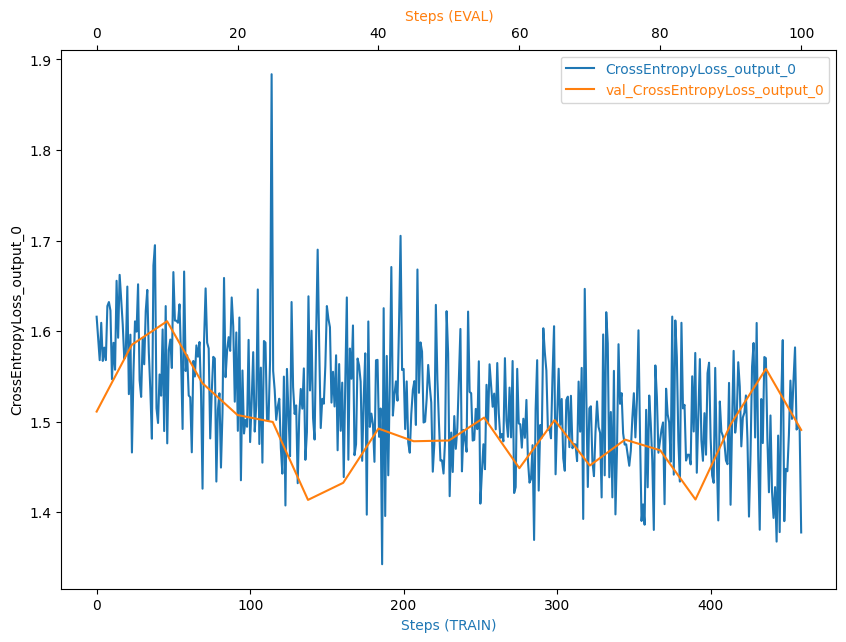

In [81]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [85]:
# TODO: Display the profiler output
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [83]:
# TODO: Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: smdebugger-bin-image-pytorch-2023-03-22-07-54-28-014
INFO:sagemaker:Creating endpoint-config with name smdebugger-bin-image-pytorch-2023-03-22-07-54-28-014
INFO:sagemaker:Creating endpoint with name smdebugger-bin-image-pytorch-2023-03-22-07-54-28-014


--------------!

In [12]:
# TODO: Run an prediction on the endpoint
from train_with_profiler import model_fn, create_data_loaders
import numpy as np
import random
import os
from PIL import Image
import cv2

data_dir = './train_data_split/test'

label_list = sorted(os.listdir(data_dir))

test_loader = create_data_loaders(data_dir, batch_size=4)


# for e in range(4):
images, labels = next(iter(test_loader))
print(f"Actual Label: {label_list[labels[0]+1]}")
response = predictor.predict(images)
labeled_predictions = list(zip(range(5), response[0]))
labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print(f"Predicted Label: {label_list[labeled_predictions[0][0]]}")
plt.imshow(images[0].T)

TypeError: create_data_loaders() missing 1 required positional argument: 'loader_type'

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances